In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [2]:
cid = "160a8e5f857f472b863ca7477d4541bf"
secret = "8ce93f2e28144c0f96e0862d5616de66"
username = '31xbb2hrrqvvi7xdwab2j35wloba'
redirect_uri = "http://localhost:9000/callback"

In [3]:
scope = 'user-library-read playlist-modify-public playlist-read-private'

client_credentials_manager = SpotifyClientCredentials(client_id = cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)

token = util.prompt_for_user_token(username,scope,cid,secret,redirect_uri)

if token:
  sp = spotipy.Spotify(auth=token)
  
else:
  print("Can't get token for", username)

In [4]:
import pandas as pd

#https://open.spotify.com/playlist/5D1yBRHxCWL40UqPMzJCNH?si=ddbb780fbf1446fa
sourcePlaylistID = '5D1yBRHxCWL40UqPMzJCNH'
sourcePlaylist = sp.user_playlist(username,sourcePlaylistID);
tracks = sourcePlaylist["tracks"];
songs = tracks["items"];

track_ids = []
track_names = []


for i in range(0, len(songs)):
  if songs[i]['track']['id']!=None:
    track_ids.append(songs[i]['track']['id'])
    track_names.append(songs[i]['track']['name'])
    
features = []


for i in range(0,len(track_ids)):
  audio_features  = sp.audio_features(track_ids[i])
  for track in audio_features:
    features.append(track)
    
    
playlist_df = pd.DataFrame(features,index = track_names)


In [5]:
playlist_df = playlist_df[["id", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]


In [6]:
playlist_df.shape


(8, 13)

In [7]:
playlist_df['ratings']=[10, 9, 9, 10, 8, 6, 8, 4]

In [8]:
playlist_df 

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,ratings
Through It All,5GcKV6j1JgaSMKG5Jl3NRN,0.02420,0.195,317267,0.680,0.000002,7,0.3200,-6.497,1,0.0376,152.290,0.2210,10
Christ Is Enough,6ylhMPeBV9kF5dYvBAO2tQ,0.00946,0.366,320987,0.812,0.000000,11,0.2920,-4.609,1,0.0340,79.962,0.2410,9
Who You Say I Am,1QoQC9g6R0K1SrPQifxaWB,0.00410,0.377,198705,0.644,0.000000,6,0.0890,-8.139,1,0.0404,171.908,0.2990,9
What A Beautiful Name,5XCtjnFMKtCT7ycDwV3Kdh,0.21200,0.417,240200,0.499,0.000000,2,0.1120,-6.364,1,0.0296,135.923,0.1440,10
Holy Spirit - Live,5Xjcst6Rle74VteHx0zczO,0.13600,0.363,489453,0.533,0.000000,2,0.3580,-8.319,1,0.0314,144.005,0.0693,8
How Great Is Our God,0jOSpB2zK2O0SNxj8ZT5lp,0.10700,0.318,305427,0.573,0.000000,1,0.0854,-5.653,1,0.0324,156.054,0.0765,6
Surrender,4CDA2cAPCUI1TYNTDgsXkH,0.03840,0.462,340565,0.479,0.000009,11,0.1130,-8.726,1,0.0274,137.967,0.2620,8
Worthy is the Lamb,4vQW0xTLnsTYT1jLT2cH5P,0.24200,0.433,362707,0.600,0.000087,9,0.1030,-6.339,1,0.0293,143.818,0.1700,4


In [9]:
X_train = playlist_df.drop(['id', 'ratings'], axis=1)
y_train = playlist_df['ratings']

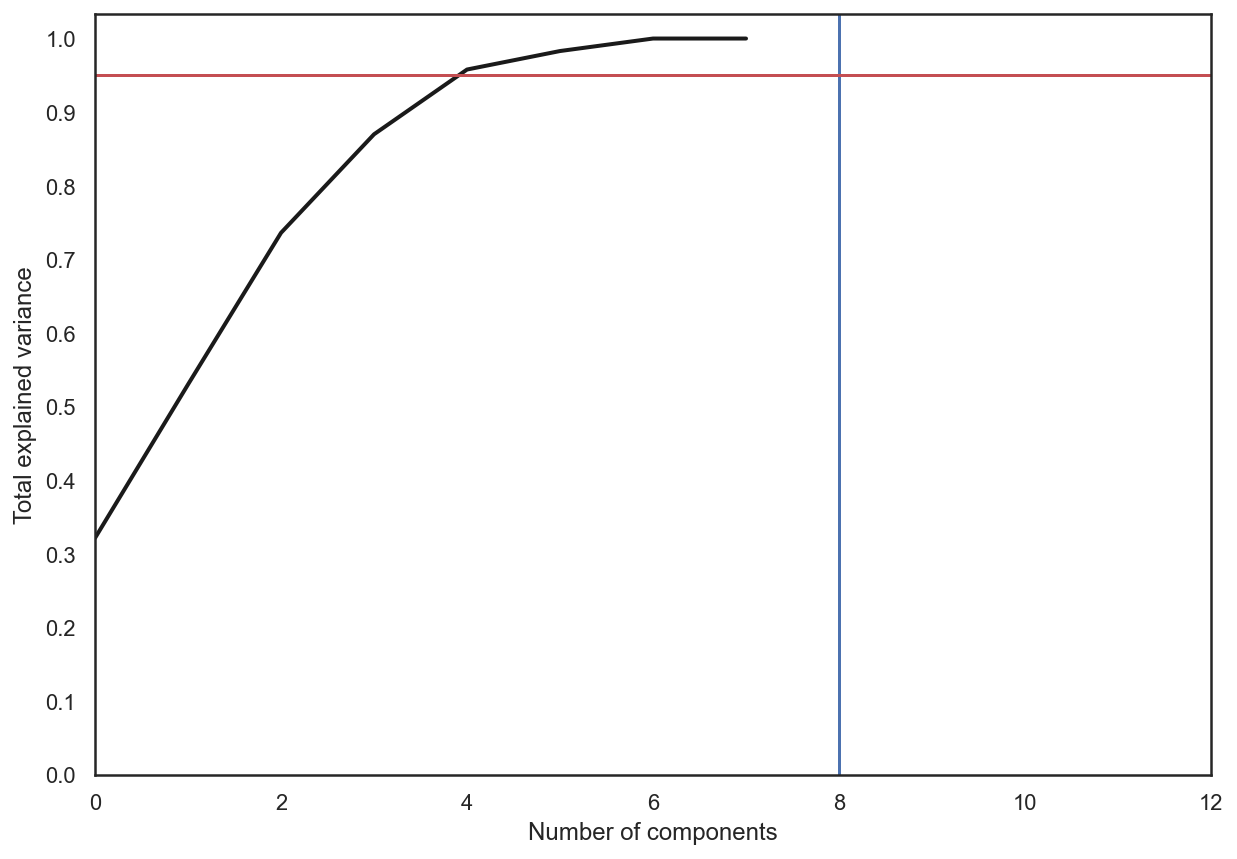

In [10]:
import numpy as np
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

X_scaled = StandardScaler().fit_transform(X_train)

pca = decomposition.PCA().fit(X_scaled)


plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='k',lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0,12)
plt.yticks(np.arange(0,1.1,0.1))
plt.axvline(8,c='b')
plt.axhline(0.95,c='r')
plt.show();

In [11]:
# Fit your dataset to the optimal pca(principal component analysis)
pca = decomposition.PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(sublinear_tf = True, ngram_range=(1,6),
                   max_features=10000)
X_names_sparse=v.fit_transform(track_names)
X_names_sparse.shape

(8, 58)

In [13]:
from scipy.sparse import csr_matrix, hstack

X_train_last = csr_matrix(hstack([X_pca, X_names_sparse]))

In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {'n_neighbors':range(1,10)}
knn = KNeighborsClassifier(n_jobs=-1)

knn_grid= GridSearchCV(knn,knn_params,cv=skf,n_jobs =-1,verbose=True)
knn_grid.fit(X_train_last,y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.    0.125 0.    0.      nan   nan   nan   nan   nan]
  warnings.warn(


({'n_neighbors': 2}, 0.125)

In [16]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'max_features':[4,7,8,10],'min_samples_leaf':[1,3,5,8],'max_depth':[3,5,8]}
rfc = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,oob_score=True)
forest_grid = GridSearchCV(rfc,parameters,n_jobs=-1,cv=skf,verbose=1)
forest_grid.fit(X_train_last,y_train)
forest_grid.best_estimator_ , forest_grid.best_score_

Fitting 2 folds for each of 48 candidates, totalling 96 fits


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 486, in fit
    self._set_oob_score_and_at

(RandomForestClassifier(max_depth=3, max_features=4, n_jobs=-1, oob_score=True,
                        random_state=42),
 nan)

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree= DecisionTreeClassifier()

tree_params = {'max_depth':range(1,11),'max_features':range(4,19)}
tree_grid = GridSearchCV(tree,tree_params,cv=skf,n_jobs=-1,verbose=True)
tree_grid.fit(X_train_last,y_train)
tree_grid.best_estimator_ , tree_grid.best_score_


Fitting 2 folds for each of 150 candidates, totalling 300 fits


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


(DecisionTreeClassifier(max_depth=5, max_features=7), 0.5)

In [18]:
rec_tracks=[]

for i in playlist_df['id'].values.tolist():
  rec_tracks += sp.recommendations(seed_tracks=[i],limit = int(len(playlist_df)/2))['tracks'];
  

rec_track_ids=[]
rec_track_names = []
for i in rec_tracks:
  rec_track_ids.append(i['id'])
  rec_track_names.append(i['name'])

In [19]:
rec_features=[]

for i in range(0,len(rec_track_ids)):
  rec_audio_features = sp.audio_features(rec_track_ids[i])
  for track in rec_audio_features:
    rec_features.append(track)
    
    
rec_playlist_df= pd.DataFrame(rec_features,index = rec_track_ids)

In [20]:
rec_playlist_df = rec_playlist_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence"]]


In [21]:
tree_grid.best_estimator_.fit(X_train_last,y_train)
rec_playlist_df_scaled = StandardScaler().fit_transform(rec_playlist_df)
X_test_pca  = pca.transform(rec_playlist_df_scaled)
X_test_names = v.transform(rec_track_names)
X_test_last = csr_matrix(hstack([X_test_pca,X_test_names]))
y_pred_class = tree_grid.best_estimator_.predict(X_test_last)

In [22]:
rec_playlist_df['ratings']=y_pred_class
rec_playlist_df = rec_playlist_df.sort_values('ratings',ascending=False)
rec_playlist_df = rec_playlist_df.reset_index()
recs_to_add = rec_playlist_df[rec_playlist_df['ratings']>=9]['index'].values.tolist()

In [23]:
#making of suggested playlist
username = '31xbb2hrrqvvi7xdwab2j35wloba'
playlist_recs =sp.user_playlist_create(username,name="Playlist Made From Python - {}".format(sourcePlaylist['name']))

In [24]:
playlist_recs

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6uTIDOHfnldc3wD4rUv6kw'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/6uTIDOHfnldc3wD4rUv6kw',
 'id': '6uTIDOHfnldc3wD4rUv6kw',
 'images': [],
 'name': 'Playlist Made From Python - Dv',
 'owner': {'display_name': 'Drishti Vashisth',
  'external_urls': {'spotify': 'https://open.spotify.com/user/31xbb2hrrqvvi7xdwab2j35wloba'},
  'href': 'https://api.spotify.com/v1/users/31xbb2hrrqvvi7xdwab2j35wloba',
  'id': '31xbb2hrrqvvi7xdwab2j35wloba',
  'type': 'user',
  'uri': 'spotify:user:31xbb2hrrqvvi7xdwab2j35wloba'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSw3OTc1MGM1NTlmMDk5YjJiZjQxZDA3ODBmOTY0MDY5MjAxMDJmNDI1',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/6uTIDOHfnldc3wD4rUv6kw/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri

In [25]:
len(recs_to_add)

14

In [26]:
sp.user_playlist_add_tracks(username,playlist_recs['id'],recs_to_add);
